## Data sources

- https://mapshaper.org/ for shapefile
- https://tj.jiangsu.gov.cn/2024/index.htm for population data
- Thanks to Google's Gemini 2.5 Pro for converting HTML to CSV

Do note that assets files are .gitignored and will not be included.

In [1]:
import shapefile
import csv
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.sans-serif'] = ['HarmonyOS Sans SC']  # Huawei make good fonts lol

r = shapefile.Reader('assets/shapefiles/js.shp')

geom = r.shape(0)
print(geom)
print(geom.shapeTypeName)
print(geom.shapeType)
print(geom.bbox)
print(geom.points)
print(r.fields)
print(r.records())

city_to_data = {}
with open('assets/js-data.csv', 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        city_to_data[row['city']] = {
            'population': float(row['population']),
            'gdp': float(row['gdp']),
            'lat': float(row['lat']),
            'lon': float(row['lon'])
        }

city_field_name = 'name'

w = shapefile.Writer('assets/shapefiles/js-edited.shp', shapeType=r.shapeType, encoding='gbk')
w.fields = r.fields[:]

w.field('lat', 'F', 10, 6)
w.field('lon', 'F', 10, 6)
w.field('population', 'F', 15, 0)
w.field('gdp', 'F', 15, 2)
w.field('per_gdp', 'F', 15, 2)

for i in range(len(r)):
    w.shape(r.shape(i))
    old_rec = r.record(i)

    city_index = [f[0] for f in r.fields[1:]].index(city_field_name)
    city = old_rec[city_index]

    lat = 0.0
    lon = 0.0
    people = 0.0
    gdp = 0.0
    per_gdp = 0.0

    if city in city_to_data:
        data = city_to_data[city]
        lat = data['lat']
        lon = data['lon']
        people = data['population']
        gdp = data['gdp']
        if people > 0:
            per_gdp = gdp / people
        else:
            per_gdp = 0.0

    new_rec = old_rec + [lat, lon, people, gdp, per_gdp]
    w.record(*new_rec)

w.close()

Polygon #0
POLYGON
5
(118.364371, 31.229373, 119.241664, 32.608232)
[(119.067452, 32.462398), (119.047022, 32.462882), (119.035909, 32.452428), (119.02373, 32.456073), (119.022495, 32.440303), (119.029455, 32.428836), (119.016434, 32.413193), (119.017556, 32.399261), (119.02749, 32.388316), (119.037425, 32.388844), (119.038435, 32.38159), (119.022551, 32.380447), (119.02171, 32.375436), (119.043823, 32.365191), (119.027322, 32.35134), (119.028445, 32.345095), (119.041971, 32.333264), (119.035853, 32.325435), (119.035572, 32.308718), (119.039838, 32.303746), (119.041073, 32.271709), (119.037088, 32.259868), (119.056563, 32.25168), (119.074748, 32.248951), (119.086029, 32.241158), (119.132332, 32.245164), (119.153772, 32.243668), (119.177232, 32.238912), (119.229036, 32.222179), (119.241664, 32.216278), (119.221403, 32.201127), (119.216239, 32.190686), (119.191095, 32.1854), (119.184529, 32.189629), (119.154446, 32.186193), (119.13671, 32.193374), (119.121332, 32.187603), (119.086871, 32

In [2]:
new_r = shapefile.Reader('assets/shapefiles/js-edited.shp', encoding='gbk')
print("\n新的属性表字段:")
print(new_r.fields)
print("\n新的属性表记录:")
print(new_r.records())


新的属性表字段:
[Field(name="DeletionFlag", field_type=FieldType.C, size=1, decimal=0), Field(name="adcode", field_type=FieldType.N, size=6, decimal=0), Field(name="name", field_type=FieldType.C, size=12, decimal=0), Field(name="center", field_type=FieldType.N, size=0, decimal=0), Field(name="centroid", field_type=FieldType.N, size=0, decimal=0), Field(name="childrenNu", field_type=FieldType.N, size=2, decimal=0), Field(name="level", field_type=FieldType.C, size=4, decimal=0), Field(name="parent", field_type=FieldType.N, size=0, decimal=0), Field(name="subFeature", field_type=FieldType.N, size=2, decimal=0), Field(name="acroutes", field_type=FieldType.N, size=0, decimal=0), Field(name="lat", field_type=FieldType.F, size=10, decimal=6), Field(name="lon", field_type=FieldType.F, size=10, decimal=6), Field(name="population", field_type=FieldType.F, size=15, decimal=0), Field(name="gdp", field_type=FieldType.F, size=15, decimal=2), Field(name="per_gdp", field_type=FieldType.F, size=15, decimal=2

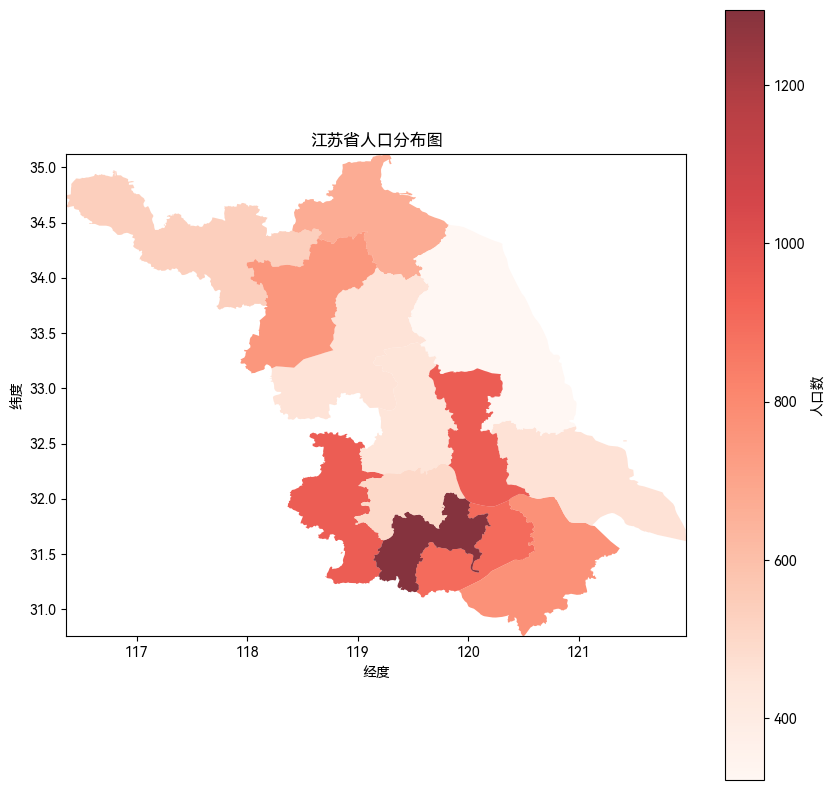

In [3]:
fig_pop, ax_pop = plt.subplots(figsize=(10, 10))
patches_pop = []
populations = []

people_index = [f[0] for f in new_r.fields[1:]].index('population')

for i in range(len(new_r)):
    shape = new_r.shape(i)
    rec = new_r.record(i)
    pop = rec[people_index]
    populations.append(pop)

    parts = list(shape.parts) + [len(shape.points)]

    for j in range(len(parts) - 1):
        start = parts[j]
        end = parts[j + 1]
        points = shape.points[start:end]
        if len(points) > 2:
            poly = Polygon(points, closed=True)
            patches_pop.append(poly)

if not patches_pop:
    print("No valid polygons to plot.")
else:
    # Normalize population values for color mapping
    pop_array = np.array(populations)
    if np.max(pop_array) > np.min(pop_array):
        norm_pop = plt.Normalize(vmin=np.min(pop_array), vmax=np.max(pop_array))
    else:
        norm_pop = plt.Normalize(vmin=0, vmax=1)

    pcollection_pop = PatchCollection(patches_pop, cmap='Reds', alpha=0.8)
    pcollection_pop.set_array(pop_array)
    pcollection_pop.set_norm(norm_pop)

    ax_pop.add_collection(pcollection_pop)

    bbox = new_r.bbox
    ax_pop.set_xlim(bbox[0], bbox[2])
    ax_pop.set_ylim(bbox[1], bbox[3])

    fig_pop.colorbar(pcollection_pop, ax=ax_pop, label='人口数')

    ax_pop.set_title('江苏省人口分布图')
    ax_pop.set_xlabel('经度')
    ax_pop.set_ylabel('纬度')
    ax_pop.set_aspect('equal')

    plt.show()

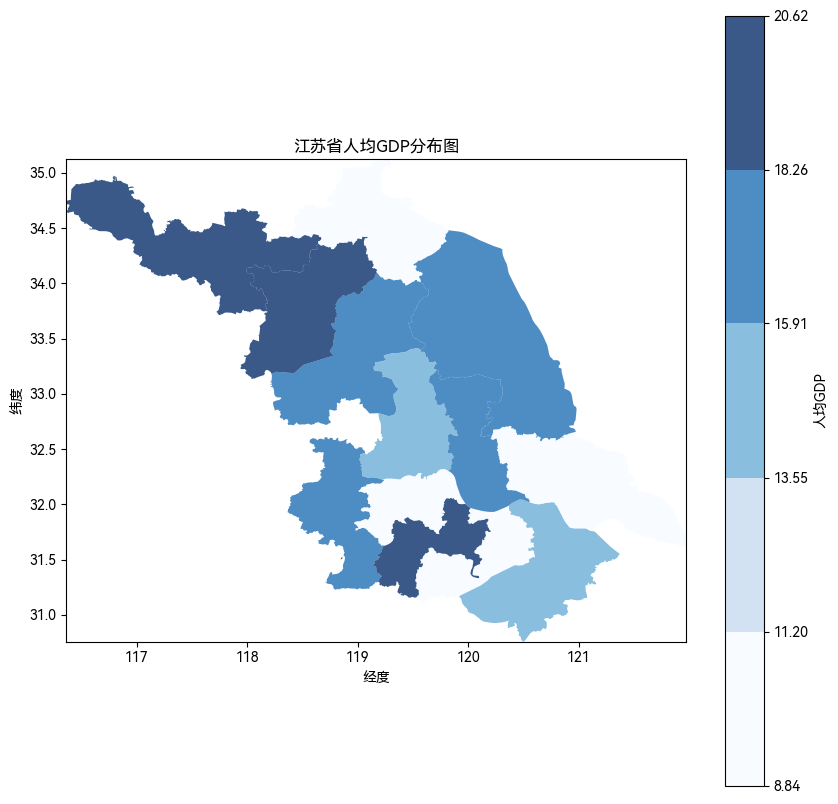

In [4]:
fig_per, ax_per = plt.subplots(figsize=(10, 10))
patches_per = []
per_gdps = []

per_gdp_index = [f[0] for f in new_r.fields[1:]].index('per_gdp')

for i in range(len(new_r)):
    shape = new_r.shape(i)
    rec = new_r.record(i)
    per = rec[per_gdp_index]
    per_gdps.append(per)

    parts = list(shape.parts) + [len(shape.points)]

    for j in range(len(parts) - 1):
        start = parts[j]
        end = parts[j + 1]
        points = shape.points[start:end]
        if len(points) > 2:
            poly = Polygon(points, closed=True)
            patches_per.append(poly)

if not patches_per:
    print("No valid polygons to plot.")
else:
    # Convert to array
    per_array = np.array(per_gdps)

    # Determine classification: assume 5 levels, based on min and max linear classification
    if np.max(per_array) > np.min(per_array):
        levels = 5
        boundaries = np.linspace(np.min(per_array), np.max(per_array), levels + 1)
        norm_per = mcolors.BoundaryNorm(boundaries, ncolors=plt.get_cmap('Blues').N, clip=True)
    else:
        norm_per = plt.Normalize(vmin=0, vmax=1)
        boundaries = np.array([np.min(per_array), np.max(per_array) + 1])  # 虚拟边界

    pcollection_per = PatchCollection(patches_per, cmap='Blues', alpha=0.8)
    pcollection_per.set_array(per_array)
    pcollection_per.set_norm(norm_per)
    ax_per.add_collection(pcollection_per)

    bbox = new_r.bbox
    ax_per.set_xlim(bbox[0], bbox[2])
    ax_per.set_ylim(bbox[1], bbox[3])

    fig_per.colorbar(pcollection_per, ax=ax_per, label='人均GDP', boundaries=boundaries, ticks=boundaries)

    ax_per.set_title('江苏省人均GDP分布图')
    ax_per.set_xlabel('经度')
    ax_per.set_ylabel('纬度')
    ax_per.set_aspect('equal')

    plt.show()